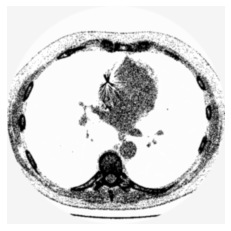

In [1]:
# image processing
import cv2
import matplotlib.pyplot as plt

# data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# machine learning
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

# etc
import os

img = cv2.imread('./2d_images/ID_0184_Z_0089.tif')
plt.imshow(img, interpolation='bicubic')
plt.axis('off')
plt.show()

In [ ]:
# !pip3.7 list

In [ ]:
# import sys
# print(sys.version)

https://www.kaggle.com/kmader/finding-lungs-in-ct-data

In [ ]:
# !ls

In [2]:
pd.read_csv('lung_stats.csv')

,img_id,lung_area_px,lung_area_mm2,lung_volume_fraction,lung_mean_hu,lung_pd95_hu,lung_pd05_hu
0,ID_0000_Z_0142.tif,57342,40318.593750,0.218742,-644.750671,-368.00,-798.0
1,ID_0001_Z_0146.tif,95955,67468.359375,0.366039,-720.042978,-544.00,-847.0
2,ID_0002_Z_0162.tif,60782,42737.343750,0.231865,-616.722632,-294.00,-777.0
3,ID_0003_Z_0132.tif,52852,37161.562500,0.201614,-664.036441,-267.55,-851.0
4,ID_0004_Z_0066.tif,81260,57135.937500,0.309982,-675.347969,-295.00,-842.0
...,...,...,...,...,...,...,...
262,ID_0262_Z_0064.tif,60734,42703.593750,0.231682,-677.077502,-387.65,-849.0
263,ID_0263_Z_0093.tif,76063,53481.796875,0.290157,-685.681304,-407.00,-834.0
264,ID_0264_Z_0080.tif,42364,29787.187500,0.161606,-545.503376,-182.00,-823.0
265,ID_0265_Z_0063.tif,63944,44960.625000,0.243927,-676.283076,-348.00,-840.0


In [ ]:
# img?

In [ ]:
# type(img)

In [ ]:
# np.max(img)

In [ ]:
# np.min(img)

In [ ]:
# np.shape(img)

In [3]:
# static value definition

IMAGE_LIB = './2d_images/'
MASK_LIB = './2d_masks/'
IMG_HEIGHT, IMG_WIDTH = 32, 32
SEED = 42

In [4]:
# lists of file names

all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']
all_images2 = [x for x in sorted(os.listdir(MASK_LIB)) if x[-4:] == '.tif']

# basic form of x_data list

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')



for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB+name, cv2.IMREAD_UNCHANGED).astype("int16").astype("float32")
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im-np.min(im))/(np.max(im)-np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')

for i, name in enumerate(all_images2):
    im = cv2.imread(MASK_LIB+name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

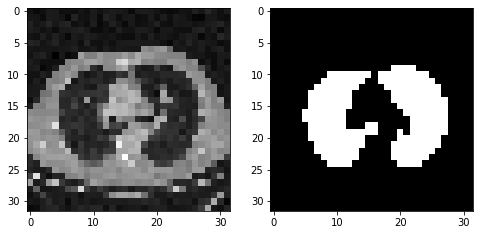

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [6]:
x_data = x_data[:,:,:, np.newaxis]
y_data = y_data[:,:,:, np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.5)

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (2. * intersection + K.epsilon()) /(K.sum(y_true_f)+K.sum(y_pred_f)+K.epsilon())

In [8]:
input_layer = Input(shape=x_train.shape[1:])

c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
p1 = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(p1)
p2 = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(p2)
p3 = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(p3)
u4 = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
u5 = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(u4)
u5 = concatenate([UpSampling2D(size=(2,2))(u5), c2], axis=-1)
u6 = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(u5)
u6 = concatenate([UpSampling2D(size=(2,2))(u6), c1], axis=-1)
c7 = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(u6)
c8 = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(c7)
u9 = Dropout(0.5)(c8)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(u9)
                                                         
model = Model(input_layer, output_layer)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   1168        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [10]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

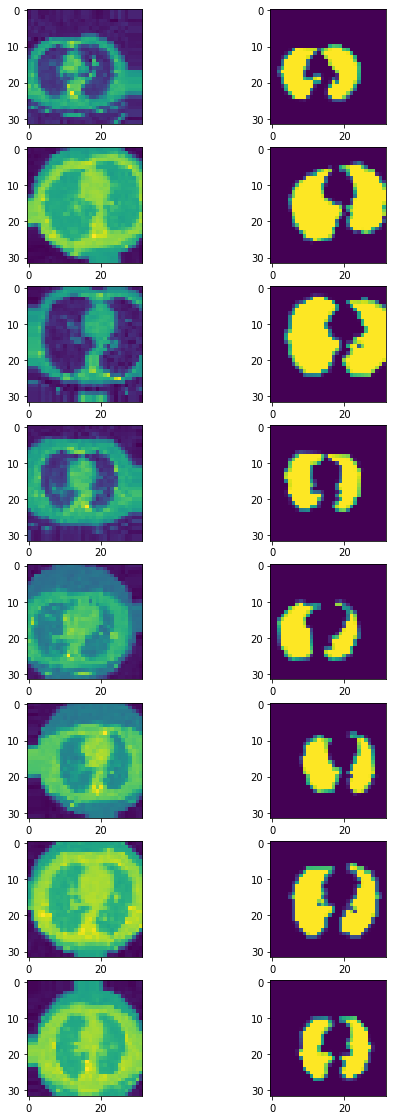

In [11]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [12]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [13]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [14]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 200 steps, validate on 134 samples
Epoch 1/10
200/200 - 10s - loss: 0.3388 - dice_coef: 0.5229 - val_loss: 0.1444 - val_dice_coef: 0.8178
Epoch 2/10
200/200 - 9s - loss: 0.1621 - dice_coef: 0.7913 - val_loss: 0.1240 - val_dice_coef: 0.8529
Epoch 3/10
200/200 - 8s - loss: 0.1378 - dice_coef: 0.8254 - val_loss: 0.1110 - val_dice_coef: 0.8725
Epoch 4/10
200/200 - 8s - loss: 0.1319 - dice_coef: 0.8362 - val_loss: 0.1068 - val_dice_coef: 0.8777
Epoch 5/10
200/200 - 7s - loss: 0.1253 - dice_coef: 0.8438 - val_loss: 0.1102 - val_dice_coef: 0.8746
Epoch 6/10
200/200 - 8s - loss: 0.1223 - dice_coef: 0.8467 - val_loss: 0.1061 - val_dice_coef: 0.8788
Epoch 7/10
200/200 - 9s - loss: 0.1205 - dice_coef: 0.8496 - val_loss: 0.1018 - val_dice_coef: 0.8821
Epoch 8/10
200/200 - 9s - loss: 0.1175 - dice_coef: 0.8516 - val_loss: 0.1010 - val_dice_coef: 0.8856
Epoch 9/10
200/200 - 9s - loss: 0.117

In [15]:
model.load_weights('lung.h5')

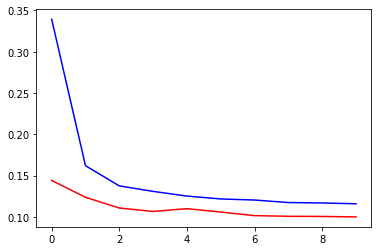

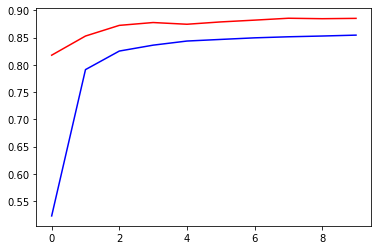

In [16]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

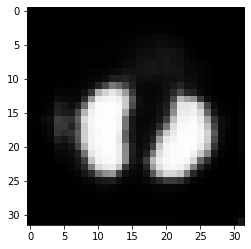

In [17]:
plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

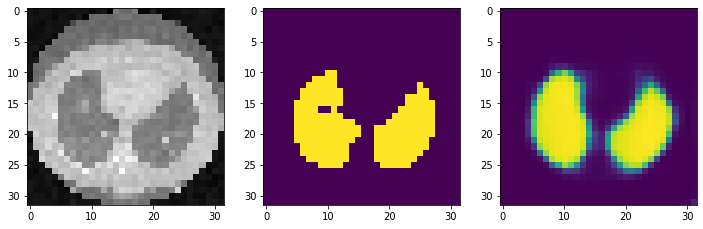

In [18]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [19]:
all_images

['ID_0000_Z_0142.tif',
 'ID_0001_Z_0146.tif',
 'ID_0002_Z_0162.tif',
 'ID_0003_Z_0132.tif',
 'ID_0004_Z_0066.tif',
 'ID_0005_Z_0066.tif',
 'ID_0006_Z_0206.tif',
 'ID_0007_Z_0211.tif',
 'ID_0008_Z_0065.tif',
 'ID_0009_Z_0114.tif',
 'ID_0010_Z_0259.tif',
 'ID_0011_Z_0156.tif',
 'ID_0012_Z_0167.tif',
 'ID_0013_Z_0047.tif',
 'ID_0014_Z_0116.tif',
 'ID_0015_Z_0136.tif',
 'ID_0016_Z_0208.tif',
 'ID_0017_Z_0061.tif',
 'ID_0018_Z_0069.tif',
 'ID_0019_Z_0088.tif',
 'ID_0020_Z_0070.tif',
 'ID_0021_Z_0066.tif',
 'ID_0022_Z_0131.tif',
 'ID_0023_Z_0241.tif',
 'ID_0024_Z_0086.tif',
 'ID_0025_Z_0112.tif',
 'ID_0026_Z_0140.tif',
 'ID_0027_Z_0125.tif',
 'ID_0028_Z_0125.tif',
 'ID_0029_Z_0059.tif',
 'ID_0030_Z_0302.tif',
 'ID_0031_Z_0232.tif',
 'ID_0032_Z_0055.tif',
 'ID_0033_Z_0278.tif',
 'ID_0034_Z_0066.tif',
 'ID_0035_Z_0224.tif',
 'ID_0036_Z_0060.tif',
 'ID_0037_Z_0150.tif',
 'ID_0038_Z_0148.tif',
 'ID_0039_Z_0112.tif',
 'ID_0040_Z_0066.tif',
 'ID_0041_Z_0336.tif',
 'ID_0042_Z_0366.tif',
 'ID_0043_Z